# DEA Coastlines raster generation <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

This code conducts raster generation for DEA Coastlines:

* Load stack of all available Landsat 5, 7, 8 and 9 satellite imagery for a location using [ODC Virtual Products](https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Virtual_products.html)
* Convert each satellite image into a remote sensing water index (MNDWI)
* For each satellite image, model ocean tides into a grid based on exact time of image acquisition
* Interpolate tide heights into spatial extent of image stack using the [FES2014 global tide model](https://github.com/GeoscienceAustralia/dea-coastlines/wiki/Setting-up-tidal-models-for-DEA-Coastlines)
* Mask out high and low tide pixels by removing all observations acquired outside of 50 percent of the observed tidal range centered over mean sea level
* Combine tidally-masked data into annual median composites representing the most representative position of the coastline at approximately mean sea level each year

This is an interactive version of the code intended for prototyping; to run this analysis at scale, use the [command line tools](DEACoastlines_generation_CLI.ipynb).

---

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-coastlines


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [2]:
pip install -r requirements.in --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import dask
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import partial
from datacube.utils.geometry import Geometry

# Load DEA Coastlines and DEA tools code
import coastlines.raster
import coastlines.utils
from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import model_tides, pixel_tides
from dea_tools.datahandling import parallel_apply

# Connect to datacube
import datacube
import odc.geo.xr

dc = datacube.Datacube(app="DEACoastlines")

# Create local dask client for parallelisation
client = create_local_dask_cluster(return_client=True)

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-coastlines/dask-worker-space/worker-a95drkmd', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-coastlines/dask-worker-space/worker-s1uf_qy5', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/Robbi/dea-coastlines/dask-worker-space/worker-fv40qnje', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36741,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:46701,Total threads: 15
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/34853/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:43223,


## Setup


### Set analysis parameters

In [4]:
study_area = 136
raster_version = 'c3_grid'
start_year = 1988
end_year = 2021

# Load analysis params from config file
config = coastlines.utils.load_config(
    config_path='configs/dea_coastlines_config.yaml')

### Load supplementary data

In [5]:
# Albers grid cells used to process the analysis
gridcell_gdf = (
    gpd.read_file(config['Input files']['grid_path']).to_crs(
        epsg=4326).set_index('id'))
gridcell_gdf.index = gridcell_gdf.index.astype(int).astype(str)
gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]

## Loading data
### Create spatiotemporal query
This establishes the spatial and temporal extent used to search for Landsat satellite data.


In [6]:
# Create query based on analysis gridcell extent
geopoly = Geometry(gridcell_gdf.iloc[0].geometry, crs=gridcell_gdf.crs)
query = {
    'geopolygon': geopoly.buffer(0.05),
    'time': (str(start_year - 1), str(end_year + 1)),  # 1999, 2021
    'dask_chunks': {
        'time': 1,
        'x': 2048,
        'y': 2048
    }
}

### Load satellite data as MNDWI
This step loads satellite data from Landsat 5, 7, 8 and 9, and returns the data as a cloud-masked array converted to the Modified Normalised Difference Water Index (MNDWI).
For Digital Earth Australia Coastlines, this is achieved using [ODC Virtual Products](https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Virtual_products.html).

In [7]:
# Load MNDWI virtual product
ds = coastlines.raster.load_water_index(
    dc,
    query,
    yaml_path=config["Virtual product"]["virtual_product_path"],
    product_name=config["Virtual product"]["virtual_product_name"],
    mask_terrain_shadow=False,
)
ds

<xarray.Dataset>
Dimensions:      (time: 1066, y: 1469, x: 1423)
Coordinates:
  * time         (time) datetime64[ns] 1987-09-12T00:43:23.359716 ... 2022-08...
  * y            (y) float64 -1.339e+06 -1.339e+06 ... -1.383e+06 -1.383e+06
  * x            (x) float64 1.366e+05 1.366e+05 ... 1.792e+05 1.792e+05
    spatial_ref  int32 32653
Data variables:
    mndwi        (time, y, x) float32 dask.array<chunksize=(1, 1469, 1423), meta=np.ndarray>
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 1469, 1423), meta=np.ndarray>
Attributes:
    crs:           epsg:32653
    grid_mapping:  spatial_ref

## Tidal modelling


### Interpolate tides into each satellite timestep
For each satellite timestep, model tide heights into a low-resolution 5 x 5 km grid (matching resolution of the FES2014 tidal model), then reproject modelled tides into the spatial extent of our satellite image. Add  this new data as a new variable in our satellite dataset to allow each satellite pixel to be analysed and filtered/masked based on the tide height at the exact moment of satellite image acquisition. 

In [8]:
ds["tide_m"], tides_lowres = pixel_tides(ds, resample=True)

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 1066/1066 [00:16<00:00, 65.60it/s]


Plot example interpolated tide surface for a single timestep:

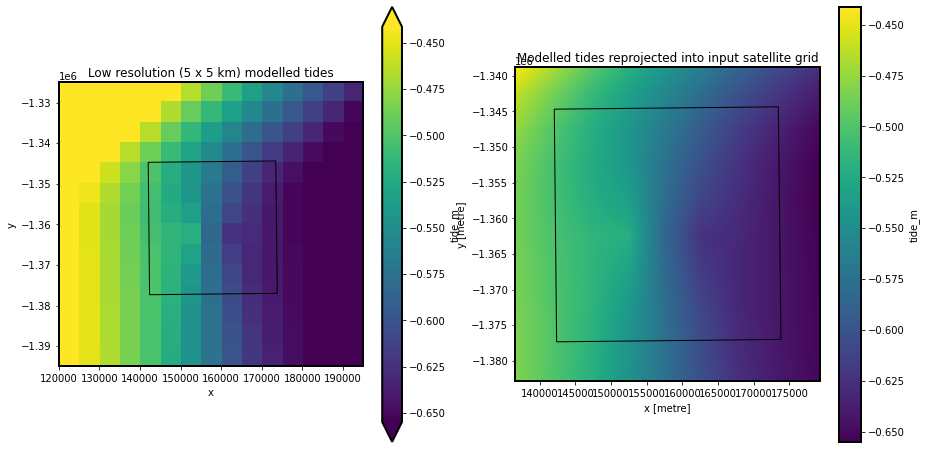

In [9]:
import matplotlib.pyplot as plt

# Plot
timestep = 15
ds_i = ds["tide_m"].isel(time=timestep)
ds_lowres_i = tides_lowres.isel(time=timestep)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
ds_lowres_i.plot.imshow(
    ax=axes[0],
    robust=True,
    cmap="viridis",
    vmin=ds_i.min().item(),
    vmax=ds_i.max().item(),
)
ds_i.plot.imshow(
    ax=axes[1],
    robust=True,
    cmap="viridis",
    vmin=ds_i.min().item(),
    vmax=ds_i.max().item(),
)
for ax in axes:
    gridcell_gdf.to_crs(ds.odc.geobox.crs).plot(
        ax=ax, facecolor="none", edgecolor="black"
    )
axes[0].set_title("Low resolution (5 x 5 km) modelled tides")
axes[1].set_title("Modelled tides reprojected into input satellite grid");

### Calculate per-pixel tide cutoffs
Based on the entire time-series of tide heights, compute the max and min satellite-observed tide height for each pixel, then calculate tide cutoffs used to restrict our data to satellite observations centred over mid-tide (0 m Above Mean Sea Level).

In [10]:
# Determine tide cutoff
tide_cutoff_min, tide_cutoff_max = coastlines.raster.tide_cutoffs(ds, tides_lowres, tide_centre=0.0)

## Generate yearly composites
Export tidally-masked MNDWI median composites for each year, and three-yearly composites used to gapfill poor data coverage areas.

In [11]:
# If output folder doesn't exist, create it
output_dir = f'data/interim/raster/{raster_version}/{study_area}_{raster_version}'
os.makedirs(output_dir, exist_ok=True)

# Iterate through each year and export annual and 3-year gapfill composites
coastlines.raster.export_annual_gapfill(ds, output_dir, tide_cutoff_min,
                                        tide_cutoff_max)

### Close Dask client

In [12]:
client.close()

distributed.nanny - WARNING - Worker process still alive after 3.9999988555908206 seconds, killing


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/dea-coastlines/issues/new).

**Last modified:** July 2022